## Cosmic Ray Parameters of interest
<ol>
    <li><a href="#total_energy">Total energy per cosmic ray</a></li>
    <li><a href="#cr_shape_size">Size and shape of cosmic ray</a></li>
    <li><a href="#normal_incidence">Angle of incidence wrt the normal of the ccd chip</a></li>
    <li><a href="#polar_angle">Angle wrt to the longest axis of the ccd chip</a></li>
    <li><a href="#cr_incidence">Cosmic ray event rate (cr/sec)</a></li>
</ol>

In [1]:
%matplotlib notebook
from astropy.io import fits
from astropy.visualization import LinearStretch, ZScaleInterval, SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
import datetime as dt
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('ggplot')
import numpy as np
import pandas as pd
from photutils.utils import random_cmap
from scipy import ndimage
import sys
import time

# Local modules
from CosmicRayLabel import CosmicRayLabel
from ComputeStats import ComputeStats

In [2]:
fname = '../data/jd4yacw0q_flt.fits'
with fits.open(fname) as hdu:
    sci2 = hdu[1].data
    dq2 = hdu[3].data
    sci1 = hdu[4].data
    dq1 = hdu[6].data
dq = np.concatenate([dq2, dq1])
sci = np.concatenate([sci2, sci1])
print(dq.shape, sci.shape)

# Initialize a scaling for plots of CR's
norm = ImageNormalize(sci, stretch=LinearStretch(), interval=ZScaleInterval())

(4096, 4096) (4096, 4096)


<b>After successful testing, I incorporated the `CosmicRayLabel` class for labeling instead of using the commented code </b>

In [3]:
# label, num_feat = lc.get_label(dq, bit_flag=8192, structure_element = np.ones((3,3)))
cr = CosmicRayLabel(fname)
cr.get_data()
cr.get_label()
# print('The number of cosmic ray labels: {}'.format(num_feat))

A total of 48741 objects were identified
After thresholding there are 38681 objects


In [4]:
num_cosmics = len(np.unique(cr.label.flatten())[1:])
print('The number of cosmic ray labels after thresholding: {}'.format(num_cosmics))

The number of cosmic ray labels after thresholding: 38681



<hr style="height:3px;border:none;color:#333;background-color:#333;" />

<a id="total_energy"></a>
<h2>Total Energy Depoistion per Cosmic Ray </h2>
<p>Use the label as a mask on the SCI array, loop through each unique label and recored the sum of the corresponding pixel in the SCI array</p>

In [5]:
def compute_total_cr_deposition_v1(label, sci):
    """Apply image label for a single chip to its corresponding science
    extension.
    
    The label should already have had the size threshold applied, with
    all CR smaller than threshold set to 0.
    
    Parameters
    ----------
    label -- image label with cr information
    sci -- science extension

    Returns
    -------
    data_per_pixel -- individual value of all pixels affected by CR
    data_per_cr -- total signal deposited by CR

    """

    unique_labels = np.unique(label)
    cr_sum = ndimage.sum(sci, labels=label, index=unique_labels[1:])
    cr_mean_energy = ndimage.mean(sci, labels=label, index=unique_labels[1:])
    return cr_sum, cr_mean_energy

In [6]:
def compute_total_cr_deposition_v2(label, sci):
    """Apply image label for a single chip to its corresponding science
    extension.
    
    The label should already have had the size threshold applied, with
    all CR smaller than threshold set to 0.
    
    Parameters
    ----------
    label -- image label with cr information
    sci -- science extension

    Returns
    -------
    data_per_pixel -- individual value of all pixels affected by CR
    data_per_cr -- total signal deposited by CR

    """

    unique_labels = pd.Series(list(set(label.ravel())),name='cr_number')
    sorted_labels = unique_labels.sort_values(axis=0)
    # The first number will always be the background (i.e. 0)
    data = []
    for cr_num in sorted_labels[1:]:
        data.append(sci[label==cr_num])
    data_per_pixel = [a for datum in data for a in datum if a > 0]
    data_per_cr = [datum.sum() for datum in data]
    return data_per_pixel, data_per_cr

In [7]:
%timeit compute_total_cr_deposition_v1(cr.label, sci)
cr_sum, cr_mean_energy = compute_total_cr_deposition_v1(cr.label, sci)

911 ms ± 65.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
start_time = time.time()
data_per_pixel, data_per_cr = compute_total_cr_deposition_v2(cr.label, sci)
end_time = time.time()
print('Total elapsed time: {:.3f} mins'.format((end_time - start_time)/60))

Total elapsed time: 6.590 mins


<IPython.core.display.Javascript object>


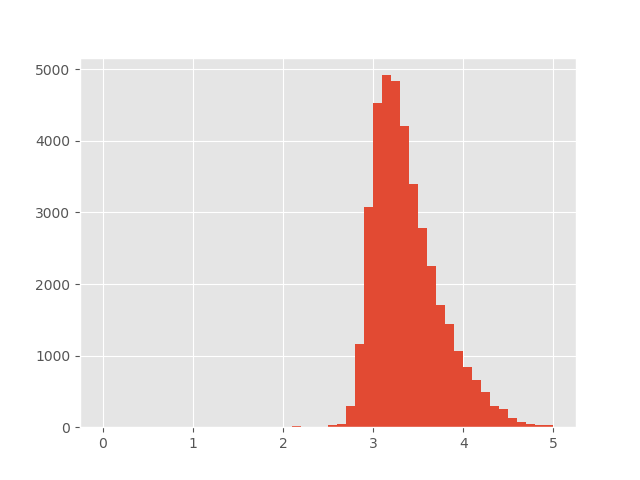

In [9]:
fig, ax = plt.subplots(1,1)
data = ax.hist(np.log10(cr_sum),bins=50, range=(0,5))


<IPython.core.display.Javascript object>


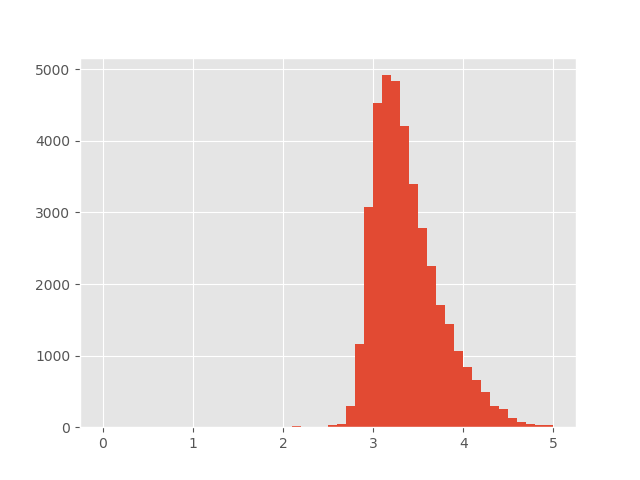

In [10]:
test = plt.hist(np.log10(data_per_cr),bins=50, range=(0,5))
plt.show()

<h3> Comparing the outputs </h3>
- let a = average energy deposited by a cosmic ray found `compute_total_cr_deposition_v1`
- let b = average energy deposited by a cosmic ray found `compute_total_cr_deposition_v2`

If a and b do not satisfy $|a - b| < 10^{-3}$, then next cell will raise an assertion error.


In [11]:
print(np.mean(cr_sum), np.mean(data_per_cr))

4293.8745901586535 4293.875


In [12]:
assert np.isclose(np.mean(cr_sum), np.mean(data_per_cr), rtol=0, atol=1e-3)


<h2>Results</h2>

From the above work we see the two methods are equivalent in their results, however the `ndimage` implementation has a significant boost in performance taking fractions of the time that my custom implementation works. So moving forward we will work with the `ndimage` implemenation.

<hr style="height:3px;border:none;color:#333;background-color:#333;" />


<a id="cr_shape_size"></a>
<h2>Size and Shape of Cosmic Ray</h2>

- Supply the label of the cosmic ray to the function `ndimage.find_objects()` to generate the smallest box containing a each individual cosmic ray identified in the label. 
    - returns a `tuple` of `slice` objects
    - First element is the `slice` along the row axis (y direction)
    - Second element is the `slice` along the column axis (x direction)
- Using the box, compute the moments of the cr distribution:
<ol>
    <li>$I_0 = \sum_{i} p_i$</li>
    <li>$I_x = \frac{1}{I_0} \sum_{i}p_i * x_i $</li>
    <li>$I_y = \frac{1}{I_0} \sum_{i} p_i * y_i $</li>
    <li>$I_{xx} = \frac{1}{I_0} \sum_{i}p_i(x_i - I_x)^2$</li>
    <li>$I_{yy} = \frac{1}{I_0} \sum_{i}p_i(y_i - I_y)^2$</li>
    <li>$I_{xy} = \frac{1}{I_0} \sum_{i}p_i(x_i - I_x)*(y_i - I_y)$</li>
</ol>
$$Size = \sqrt{\frac{I_{xx} + I_{yy}}{2}} $$
<p></p>
$$Anisotropy = \sqrt{\frac{(I_{xx} - I_{yy})^2 + 4I^2_{xy}}{(I_{xx} + I_{yy})^2}}$$

In [13]:
def compute_shape(label, sci):
    cr_locs = ndimage.find_objects(label)
    return cr_locs

In [14]:
sizes = np.bincount(cr.label.ravel())
index = np.argmax(sizes[1:])
print(index)


10404


In [15]:
cr_locs = compute_shape(cr.label, sci)

### Custom Center of Intensity Calculation

In [16]:
edge_cr_index = 1977
cr_locs[index]

(slice(1133, 1230, None), slice(1396, 1537, None))

In [17]:
tmp = cr_locs[index]
y_slice = tmp[0]
x_slice = tmp[1]
print(y_slice.start, y_slice.stop)
print(x_slice.start, x_slice.stop)

1133 1230
1396 1537


In [18]:
y_coords = np.linspace(y_slice.start, y_slice.stop, int(y_slice.stop - y_slice.start)+1)

In [19]:
y_coords

array([1133., 1134., 1135., 1136., 1137., 1138., 1139., 1140., 1141.,
       1142., 1143., 1144., 1145., 1146., 1147., 1148., 1149., 1150.,
       1151., 1152., 1153., 1154., 1155., 1156., 1157., 1158., 1159.,
       1160., 1161., 1162., 1163., 1164., 1165., 1166., 1167., 1168.,
       1169., 1170., 1171., 1172., 1173., 1174., 1175., 1176., 1177.,
       1178., 1179., 1180., 1181., 1182., 1183., 1184., 1185., 1186.,
       1187., 1188., 1189., 1190., 1191., 1192., 1193., 1194., 1195.,
       1196., 1197., 1198., 1199., 1200., 1201., 1202., 1203., 1204.,
       1205., 1206., 1207., 1208., 1209., 1210., 1211., 1212., 1213.,
       1214., 1215., 1216., 1217., 1218., 1219., 1220., 1221., 1222.,
       1223., 1224., 1225., 1226., 1227., 1228., 1229., 1230.])

In [20]:
x_coords = np.linspace(x_slice.start, x_slice.stop, int(x_slice.stop - x_slice.start)+1)

In [21]:
x_coords

array([1396., 1397., 1398., 1399., 1400., 1401., 1402., 1403., 1404.,
       1405., 1406., 1407., 1408., 1409., 1410., 1411., 1412., 1413.,
       1414., 1415., 1416., 1417., 1418., 1419., 1420., 1421., 1422.,
       1423., 1424., 1425., 1426., 1427., 1428., 1429., 1430., 1431.,
       1432., 1433., 1434., 1435., 1436., 1437., 1438., 1439., 1440.,
       1441., 1442., 1443., 1444., 1445., 1446., 1447., 1448., 1449.,
       1450., 1451., 1452., 1453., 1454., 1455., 1456., 1457., 1458.,
       1459., 1460., 1461., 1462., 1463., 1464., 1465., 1466., 1467.,
       1468., 1469., 1470., 1471., 1472., 1473., 1474., 1475., 1476.,
       1477., 1478., 1479., 1480., 1481., 1482., 1483., 1484., 1485.,
       1486., 1487., 1488., 1489., 1490., 1491., 1492., 1493., 1494.,
       1495., 1496., 1497., 1498., 1499., 1500., 1501., 1502., 1503.,
       1504., 1505., 1506., 1507., 1508., 1509., 1510., 1511., 1512.,
       1513., 1514., 1515., 1516., 1517., 1518., 1519., 1520., 1521.,
       1522., 1523.,

In [22]:
xx, yy = np.meshgrid(x_coords, y_coords)

In [23]:
print(xx.shape, xx.shape[0]*xx.shape[1])

(98, 142) 13916


In [24]:
xx

array([[1396., 1397., 1398., ..., 1535., 1536., 1537.],
       [1396., 1397., 1398., ..., 1535., 1536., 1537.],
       [1396., 1397., 1398., ..., 1535., 1536., 1537.],
       ...,
       [1396., 1397., 1398., ..., 1535., 1536., 1537.],
       [1396., 1397., 1398., ..., 1535., 1536., 1537.],
       [1396., 1397., 1398., ..., 1535., 1536., 1537.]])

In [25]:
yy

array([[1133., 1133., 1133., ..., 1133., 1133., 1133.],
       [1134., 1134., 1134., ..., 1134., 1134., 1134.],
       [1135., 1135., 1135., ..., 1135., 1135., 1135.],
       ...,
       [1228., 1228., 1228., ..., 1228., 1228., 1228.],
       [1229., 1229., 1229., ..., 1229., 1229., 1229.],
       [1230., 1230., 1230., ..., 1230., 1230., 1230.]])

In [26]:
# Create a list of all of the possible coordinate locations on the grid
positions = np.vstack([yy.ravel(), xx.ravel()])

In [27]:
grid_coords = list(zip(map(int, positions[0]), map(int, positions[1])))
# for pos in grid_coords:
#     print(pos[0], pos[1])

In [28]:
I_0 = ndimage.sum(sci, labels=cr.label, index=[index+1])[0]
print(I_0)

237822.79039001465


In [29]:
I_x = 0
I_y = 0
cr_coords = []
for r in grid_coords:
    if cr.label[r[0]][r[1]] == index+1:
#         print(sci[r[0]][r[1]])
        I_x += sci[r[0]][r[1]] * r[1]
        I_y += sci[r[0]][r[1]] * r[0]
        cr_coords.append(r)

In [30]:
custom_cm = (I_y/I_0, I_x/I_0)

In [31]:
shifted_origin = (I_y/I_0 - y_slice.start, I_x/I_0 - x_slice.start)

In [33]:
print(custom_cm)
print(shifted_origin)

(1183.4578643291404, 1462.4536534438876)
(50.45786432914042, 66.45365344388756)


***

In [34]:
extrema = ndimage.extrema(sci, labels=cr.label, index=[index+1])

In [35]:
extrema

(array([45.774265], dtype=float32),
 array([4698.877], dtype=float32),
 [(1200, 1435)],
 [(1204, 1433)])

In [36]:
min_pos = extrema[-2][0]
max_pos = extrema[-1][0]

In [37]:
min_pos

(1200, 1435)

In [38]:
min_pos1 = (min_pos[0] - y_slice.start,min_pos[1] - x_slice.start)
max_pos1 = (max_pos[0] - y_slice.start, max_pos[1] - x_slice.start)

In [39]:
min_pos1

(67, 39)

In [40]:
box_sci_slice = sci[cr_locs[index][0], cr_locs[index][1]]
box_label_slice = cr.label[cr_locs[index][0], cr_locs[index][1]]

In [41]:
print(box_sci_slice[0][0], box_sci_slice[-1][0],box_sci_slice[0][-1],box_sci_slice[-1][-1])

92.61244 104.84983 120.74858 89.59809


In [43]:
def mk_patch(r_cm, c='red'):
    CR_center = patches.Rectangle((r_cm[1]-0.5,r_cm[0]-0.5), 
                              width=1, height=1, 
                              alpha=1.0, fill=False,
                              linewidth=1.75, color=c)
    return CR_center

<IPython.core.display.Javascript object>


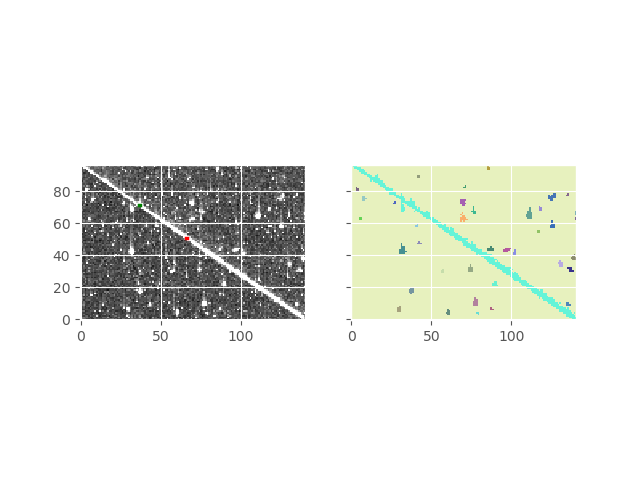

In [44]:
fig, (ax, ax1) = plt.subplots(1,2, sharex=True, sharey=True)
ax.imshow(box_sci_slice, norm=norm, cmap='gray', origin='lower')
ax1.imshow(box_label_slice, cmap=random_cmap(len(cr_locs)),origin='lower')
patch1 = mk_patch(r_cm= shifted_origin ,c='red')
patch2 = mk_patch(r_cm = max_pos1, c='green')
ax.add_patch(patch1)
ax.add_patch(patch2)

In [46]:
r_cm = ndimage.measurements.center_of_mass(sci, labels=cr.label, index=np.unique(cr.label)[1:])
# r_cm = ndimage.measurements.center_of_mass(sci, labels=label, index=[index+1])
print(len(r_cm))

38681


In [47]:
# (row variable, column variable) <--> (y, x)
# r_cm.append(custom_cm)
# r_cm = list(r_cm[0])
print(r_cm)

[(0.29413725726098133, 32.90531796303382), (0.21720031540879886, 274.47236143590743), (0.06348543509777996, 352.08239909631874), (0.7485238804527954, 855.7088011743003), (2.847767643941191, 874.8417047940521), (0.4508886276692323, 922.2395769987122), (1.6459983817739978, 1008.8454075284102), (0.6841457231817656, 1031.2033483349303), (0.49644955338834196, 1680.24849988574), (0.32616995414504973, 1797.487055321464), (0.4094960236421765, 1838.2077840527388), (0.4107291037256862, 2019.3973611957135), (0.45454427150523385, 2028.979691448956), (0.0, 2123.508684959792), (0.0, 2228.750457318915), (1.2169204331395478, 2577.0208491893236), (3.024857434087344, 2654.0000614565633), (0.23936288512028628, 3164.8573182202085), (0.26417220464580393, 3238.084124470095), (0.6293571966631415, 3361.02179457325), (0.8328638643692873, 3404.467258615528), (0.0, 3663.5085777604163), (0.8427866370202126, 3717.973130104505), (0.17766401824447098, 3772.8000990797123), (0.055316135329028036, 3962.37641900099), (2

In [48]:
print(cr_locs[index+1])

(slice(1133, 1137, None), slice(1881, 1886, None))


<IPython.core.display.Javascript object>


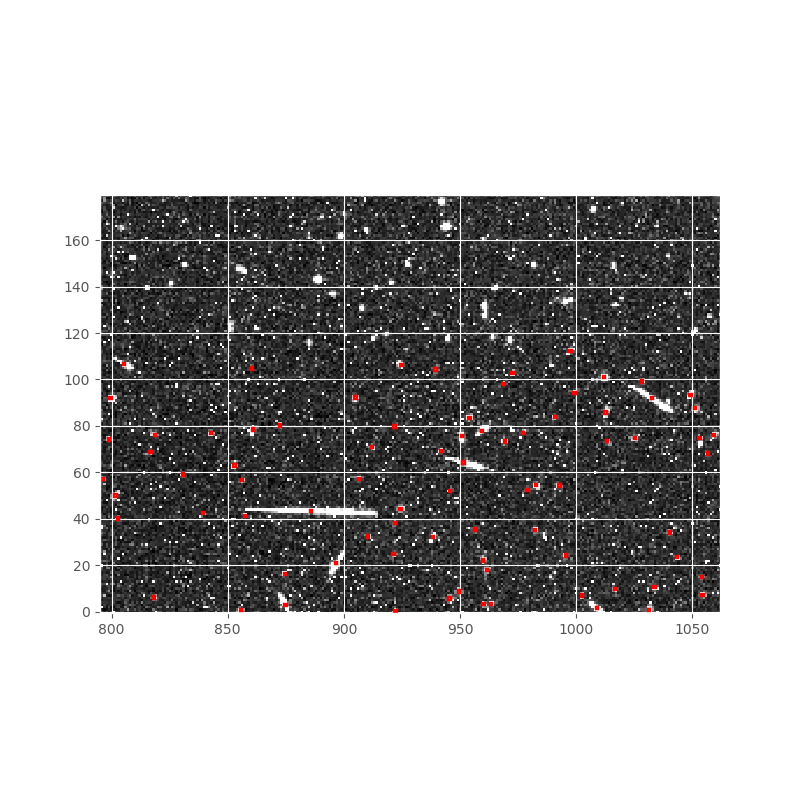

In [50]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(sci, norm=norm, cmap='gray',origin='lower')

for cm in r_cm[:1000]:
    patch = mk_patch(cm)
    ax.add_patch(patch)

# Use CM to compute $I_{xx}$ and $I_{yy}$, then compute the size

In [51]:
def mk_grid(slice_tuple):
    """Build a meshgrid from a tuple of python slice objects

    Parameters
    ----------
    slice_tuple

    Returns
    -------

    """
    y_slice = slice_tuple[0]
    x_slice = slice_tuple[1]


    if int(x_slice.stop) == 4096:
        print('Cosmic ray struck the edge!!!!!!!!!!!!')
        y_coords = np.linspace(y_slice.start, y_slice.stop,
                               int(y_slice.stop - y_slice.start)+1)

        x_coords = np.linspace(x_slice.start, x_slice.stop,
                               int(x_slice.stop - x_slice.start)+1,
                               endpoint=False)

    elif int(y_slice.stop)  == 4096:
        print('Cosmic ray struck the edge!!!!!!!!!!!!')
        y_coords = np.linspace(y_slice.start, y_slice.stop,
                               int(y_slice.stop - y_slice.start)+1,
                               endpoint=False)
        x_coords = np.linspace(x_slice.start, x_slice.stop,
                               int(x_slice.stop - x_slice.start)+1)

    else:
        y_coords = np.linspace(y_slice.start, y_slice.stop,
                               int(y_slice.stop - y_slice.start) + 1)

        x_coords = np.linspace(x_slice.start, x_slice.stop,
                               int(x_slice.stop - x_slice.start) + 1)

    xx, yy = np.meshgrid(x_coords, y_coords)
    positions = np.vstack([yy.ravel(), xx.ravel()])
    grid_coords = list(zip(map(int, positions[0]), map(int, positions[1])))

    return grid_coords

In [52]:
def compute_first_moment(label, sci):
    """

    Parameters
    ----------
    sci
    label

    Returns
    -------

    """
    r_cm = ndimage.measurements.center_of_mass(sci,
                                               labels=label,
                                               index=np.unique(label)[1:])
    print(len(r_cm))
    return r_cm


def compute_second_moment(I_0, sci, label, I_ci, grid_coords, index):
    """

    Parameters
    ----------
    I_0
    p_i
    r_i
    I_ci

    Returns
    -------

    """
    second_moment = [0,0]
    for r_i in grid_coords:
        if label[r_i[0]][r_i[1]] == index:
            second_moment += (1/I_0) * sci[r_i[0]][r_i[1]] * (np.asarray(r_i) - np.asarray(I_ci))**2

    return np.asarray(second_moment)


In [53]:
grid_coords = mk_grid(cr_locs[index])

In [54]:
grid_coords

[(1133, 1396),
 (1133, 1397),
 (1133, 1398),
 (1133, 1399),
 (1133, 1400),
 (1133, 1401),
 (1133, 1402),
 (1133, 1403),
 (1133, 1404),
 (1133, 1405),
 (1133, 1406),
 (1133, 1407),
 (1133, 1408),
 (1133, 1409),
 (1133, 1410),
 (1133, 1411),
 (1133, 1412),
 (1133, 1413),
 (1133, 1414),
 (1133, 1415),
 (1133, 1416),
 (1133, 1417),
 (1133, 1418),
 (1133, 1419),
 (1133, 1420),
 (1133, 1421),
 (1133, 1422),
 (1133, 1423),
 (1133, 1424),
 (1133, 1425),
 (1133, 1426),
 (1133, 1427),
 (1133, 1428),
 (1133, 1429),
 (1133, 1430),
 (1133, 1431),
 (1133, 1432),
 (1133, 1433),
 (1133, 1434),
 (1133, 1435),
 (1133, 1436),
 (1133, 1437),
 (1133, 1438),
 (1133, 1439),
 (1133, 1440),
 (1133, 1441),
 (1133, 1442),
 (1133, 1443),
 (1133, 1444),
 (1133, 1445),
 (1133, 1446),
 (1133, 1447),
 (1133, 1448),
 (1133, 1449),
 (1133, 1450),
 (1133, 1451),
 (1133, 1452),
 (1133, 1453),
 (1133, 1454),
 (1133, 1455),
 (1133, 1456),
 (1133, 1457),
 (1133, 1458),
 (1133, 1459),
 (1133, 1460),
 (1133, 1461),
 (1133, 14

In [59]:
I_0 = ndimage.sum(sci, labels=cr.label, index=[index+1])[0]
print(I_0)
second_moment = compute_second_moment(I_0, sci, cr.label, r_cm[index+1],
                                      grid_coords, index+1)

237822.79039001465


In [60]:
np.sqrt(second_moment.sum()/2)

301.0439980404722

In [15]:
I_0 = ndimage.sum(sci, labels=cr.label, index=[index+1])[0]
I_yy = 0
I_xx = 0
for r in grid_coords:
    if label[r[0]][r[1]] == index+1:
#         print(sci[r[0]][r[1]])
        I_xx += compute_I_xx(I_0, sci[r[0]][[r[1]]], r[1], r_cm[0][1])
        I_yy += compute_I_yy(I_0, sci[r[0]][[r[1]]], r[0], r_cm[0][0])
        

NameError: name 'label' is not defined

### Computing the $I_{xy}$
$I_{xy} = \frac{1}{I_0} \sum_{i}p_i(x_i - I_x)*(y_i - I_y)$

In [226]:
def compute_cross_moment(I_0, sci, label, I_ci, grid_coords, index):
    I_xy = 0
    for r_i in grid_coords:
        if label[r_i[0]][r_i[1]] == index:
            I_xy += (1/I_0) * sci[r_i[0]][r_i[1]] * (r_i[0] - I_ci[0]) * (r_i[1] - I_ci[1])
    return I_xy

### Testing computation of sizes

In [229]:
I_0 = ndimage.sum(sci, labels=label, index=[index])[0]

In [230]:
grid_coords = cs.mk_grid(cr_locs[index-1])

In [231]:
grid_coords

[(0, 32),
 (0, 33),
 (0, 34),
 (0, 35),
 (1, 32),
 (1, 33),
 (1, 34),
 (1, 35),
 (2, 32),
 (2, 33),
 (2, 34),
 (2, 35)]

In [236]:
cross_momements = compute_cross_moment(I_0, sci, label, r_cm[0],grid_coords, index+1)

In [237]:
R_cm = cs.compute_first_moment(label, sci)

38681


In [234]:
len(R_cm)

38681

In [238]:
cr_locs = ndimage.find_objects(label)
cr_locs = [cr for cr in cr_locs if cr is not None]

In [239]:
cr_deposition = cs.compute_total_cr_deposition_v1(label, sci)

In [240]:
len(R_cm), len(cr_deposition), len(cr_locs), len(np.unique(label)[1:])

(38681, 38681, 38681, 38681)

In [241]:
sizes = {}
second_moments = {}
loop_obj = zip(np.unique(label)[1:], R_cm, cr_deposition, cr_locs)
for int_id, r_cm, I_0, loc in loop_obj:
    grid_coords = cs.mk_grid(loc)
    second_moment = cs.compute_second_moment(I_0, sci, label,
                                              r_cm, grid_coords, int_id)
    second_moments[int_id] = second_moment
    sizes[int_id] = np.sqrt(second_moment.sum()/2)

Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edg

In [242]:
cosmic_ray_sizes = list(sizes.values())

In [243]:
np.max(cosmic_ray_sizes)

32.540136657939513

In [244]:
cross_moments = {}
loop_obj = zip(np.unique(label)[1:], R_cm, cr_deposition, cr_locs)
for int_id, r_cm, I_0, loc in loop_obj:
    grid_coords = cs.mk_grid(loc)
    cross_moment = compute_cross_moment(I_0, sci, label, r_cm, grid_coords, int_id)
    cross_moments[int_id] = cross_moment
    

Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edge!!!!!!!!!!!!
Cosmic ray struck the edg

In [247]:
print(cross_moments[index],second_moments[index])
index

0.0209477278584 [ 0.20762053  0.22034961]


1

$$Anisotropy = \sqrt{\frac{(I_{xx} - I_{yy})^2 + 4I^2_{xy}}{(I_{xx} + I_{yy})^2}}$$


In [176]:
def compute_anistropy(second_moments, cross_moment):
    return np.sqrt(((second_moments[0] - second_moments[1])**2 + 4*cross_moment**2)/(second_moment.sum())**2)

In [184]:
compute_anistropy(second_moments[index+1], cross_moments[index+1])

3366.2871615934364

<h2>Results</h2>

From the above test we see that the centroiding calculation works great, and all of the higher order moment can be readilty calculated building on the zeroth, first, and second moments. All of the code written here has been implemented in a class `ComputeStats()`

<hr style="height:3px;border:none;color:#333;background-color:#333;" />

<a id="normal_incidence"></a>
<h2>Angle of incidence wrt to plane of CCD</h2>
<p> The idea here is to use a thickness map of the CCD to compute the angle of incidence of the cosmic ray. By counting up the number of pixels the cosmic ray has traversed, we can use the average thickness ($\Delta z$) of the detector and the average pixel size ($\overline{s}$) to solve for theta:</p>
$$ tan(\theta)=\frac{\Delta z}{n_{pix}*\overline{s}}$$



<a id="polar_angle"></a>
<h2> Polar angle wrt to defined CCD axis</h2>
<p>The idea here is to use the results returned by `find_objects` to compute the angle between the CCD axes